# Detecting depression in Tweets using Baye's Theorem

# Installing and importing libraries

In [1]:
!pip install wordcloud
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\namitha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading the Data

In [2]:
tweets = pd.read_csv('sentiment_tweets3.csv')
tweets.head(20)

,ItemID,Sentiment,SentimentText
0,106,0,just had a real good moment. i missssssssss hi...
1,217,0,is reading manga http://plurk.com/p/mzp1e
2,220,0,@comeagainjen http://twitpic.com/2y2lx - http:...
3,288,0,@lapcat Need to send 'em to my accountant tomo...
4,540,0,ADD ME ON MYSPACE!!! myspace.com/LookThunder
5,624,0,so sleepy. good times tonight though
6,701,0,"@SilkCharm re: #nbn as someone already said, d..."
7,808,0,23 or 24ï¿½C possible today. Nice
8,1193,0,nite twitterville workout in the am -ciao
9,1324,0,"@daNanner Night, darlin'! Sweet dreams to you"


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
ItemID           10314 non-null int64
Sentiment        10314 non-null int64
SentimentText    10314 non-null object
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


# Splitting the Data in Training and Testing Sets

As you can see, I used almost all the data for training: 98% and the rest for testing.

In [4]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
ItemID           10314 non-null int64
Sentiment        10314 non-null int64
SentimentText    10314 non-null object
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [6]:
trainData['Sentiment'].value_counts()

0    7839
1    2272
Name: Sentiment, dtype: int64

In [7]:
trainData.head()

,ItemID,Sentiment,SentimentText
0,106,0,just had a real good moment. i missssssssss hi...
1,217,0,is reading manga http://plurk.com/p/mzp1e
2,220,0,@comeagainjen http://twitpic.com/2y2lx - http:...
3,288,0,@lapcat Need to send 'em to my accountant tomo...
4,540,0,ADD ME ON MYSPACE!!! myspace.com/LookThunder


In [8]:
testData['Sentiment'].value_counts()

0    161
1     42
Name: Sentiment, dtype: int64

In [9]:
testData.head()

,ItemID,Sentiment,SentimentText
58,5865,0,Watching the steam trains go back and forth in...
96,10509,0,Nothin' like a good book and some spring clean...
113,12145,0,@superhootie Maybe... just maybe!
179,20370,0,@Clouds2287 Hm. So I take it the essays are no...
257,28175,0,"@brob108 good stuff Woop, looking forward to..."


# Wordcloud Analysis

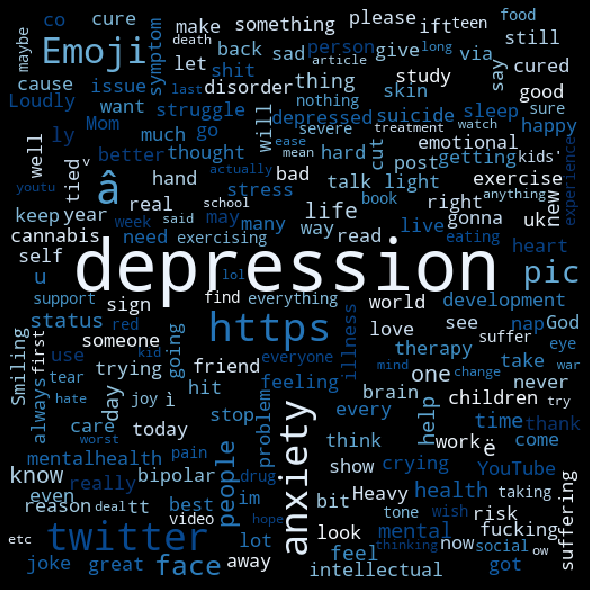

In [10]:
depressive_words = ' '.join(list(tweets[tweets['Sentiment'] == 1]['SentimentText']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

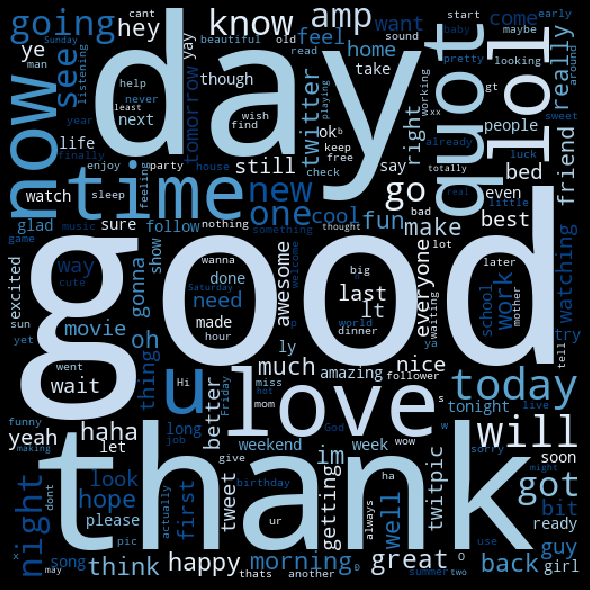

In [11]:
positive_words = ' '.join(list(tweets[tweets['Sentiment'] == 0]['SentimentText']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

#Pre-processing the data for the training: Tokenization, stemming, and removal of stop words

In [12]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [13]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['SentimentText'], trainData['Sentiment']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [14]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [15]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['SentimentText'])
metrics(testData['Sentiment'], preds_tf_idf)

Precision:  0.8823529411764706
Recall:  0.35714285714285715
F-score:  0.5084745762711864
Accuracy:  0.8571428571428571


In [16]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['SentimentText'])
metrics(testData['Sentiment'], preds_bow)

Precision:  0.8888888888888888
Recall:  0.19047619047619047
F-score:  0.3137254901960784
Accuracy:  0.8275862068965517


# Predictions with TF-IDF

# Depressive Tweets

In [17]:
pm = process_message('Lately I have been feeling unsure of myself as a person & an artist')
sc_tf_idf.classify(pm)

True

In [18]:
pm = process_message('Extreme sadness, lack of energy, hopelessness')
sc_tf_idf.classify(pm)


True

In [19]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_tf_idf.classify(pm)

True

In [20]:
pm = process_message('I am officially done with @kanyewest')
sc_tf_idf.classify(pm)


True

In [21]:
pm = process_message('Feeling down...')
sc_tf_idf.classify(pm)


True

In [22]:
pm = process_message('My depression will not let me work out')
sc_tf_idf.classify(pm)


True

# Positive Tweets

In [23]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_tf_idf.classify(pm)


False

In [24]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_tf_idf.classify(pm)


False

In [25]:
pm = process_message('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_tf_idf.classify(pm)

False

In [26]:
pm = process_message('It’s the little things that make me smile. Got our new car today and this arrived with it')
sc_tf_idf.classify(pm)

False

# Predictions with Bag-of-Words (BOW)

# Depressive tweets

In [27]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_bow.classify(pm)

True

In [28]:
pm = process_message('My depression will not let me work out')
sc_bow.classify(pm)

True

In [29]:
pm = process_message('Feeling down...')
sc_bow.classify(pm)

False

# Positive Tweets

In [30]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_bow.classify(pm)

False

In [31]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_bow.classify(pm)

False

In [32]:
pm = process_message('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_bow.classify(pm)

False

In [33]:
total_data = pd.read_csv("sentiment_tweets3.csv", encoding="ISO-8859-1")

In [34]:
import json, nltk
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

In [35]:
pd.set_option('display.max_colwidth', -1)

In [36]:
tweet = total_data.columns.values[2]
sentiment = total_data.columns.values[1]
tweet, sentiment

('SentimentText', 'Sentiment')

In [37]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

In [38]:
import re

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    return tweet


In [39]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
final_vectorized_data = count_vectorizer.fit_transform(total_data['processed_tweet'])  
 

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.2, random_state=69) 

In [42]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier
#from sklearn.feature_extraction.text import CountVectorizer

comment2 = [" @cindolce awe........thanks sweets!! Thank you for all your advice, I owe you!! "]
 
      
check = count_vectorizer.transform(comment2).toarray() 
check
model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(check)
print(predicted_naive)

[0]
